In [1]:
# 將 training data 的 pickle 檔載入
import pickle
import pandas as pd
import monpa as mp
import numpy as np
import jieba
import os
import tqdm
from keras import utils
import tensorflow as tf

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [19]:
len(pd.read_csv(train_path))

27000

In [4]:
def create_ngram_set(input_list, ngram_value=2):
    '''
    返回 不重复的 n_gram 词组
    :param input_list: 输入的列表,也就是 imdb 数据中的每个样本（list形式）
    :param ngram_value: 几元组
    :return: 返回不重复的 n_gram 词组，用于做元组表
    '''
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

def add_ngram(sequences, token_indice, ngram_range=2):
    '''
    对每一个句子进行 n_gram 特征的加入 生成 所有 token 的字典 和 index 字典
    然后 遍历 sequences ，每一个句子 按照几元组的 形式分割，到 token_indice 中去索引，如果有值就加入
    :param sequences: 【【word1，word2，word3.。。】，【word1，word2，word3.。。】。。。】
    :param token_indice: 生成多元组和原始 token 的字典
    :param ngram_range: n_gram 中的 n
    :return: 返回新的 加入 n_gram 特征的列表中的列表
    '''
    new_sequences = []
    for input_list in sequences:
        # 将 列表 进行复制
        new_list = input_list[:]
        # 抽取几元组特征
        for ngram_value in range(2, ngram_range + 1):
            # 抽取 2 元组就在 len（list） 到 len（list）- 2 上进行选取
            for i in range(len(new_list) - ngram_value + 1):
                n_gram = tuple(input_list[i:i + ngram_value])
                if n_gram in token_indice:
                    list(new_list).append(token_indice[n_gram])
        new_sequences.append(new_list)
    return new_sequences

# 參數

In [83]:
print(np.mean(list(map(len,x_train))))
ngram_range = 3  # 抽取的是二元组，可以自己定
ngram_set = set()
max_features = 25000  # 词典最大长度
max_len = 400  # 刚刚通过 np.mean(list(map(len,x_train))) 查看了句子的平均长度 设置为400合适
batch_size = 30
embedding_dims = 100  # 每个单词的编码长度
epoch = 60  # 训练几个 epoch

400.0


In [70]:
train_path='./train_dataset100.csv'
test_path='./test_dataset100.csv'
unknown_path='./unknown.csv'

news_class=["tech", "edu", "sports", "health", "travel", "politics"]
num_classes=len(news_class)
classes_dict={news_class[i]:i for i in range(num_classes)}

x_train=[np.array(st.split()).astype(int) for st in pd.read_csv(train_path)['did_content'] ]
#x_train=np.array([list(st) for st in x_train])
#x_train=x_train.astype(int)
y_train=[classes_dict[c] for c in pd.read_csv(train_path)['Label']]
y_train = utils.to_categorical(y_train, num_classes=num_classes)

x_test=[np.array(st.split()).astype(int) for st in pd.read_csv(test_path)['did_content'] ]
y_test=[classes_dict[c] for c in pd.read_csv(test_path)['Label']]
y_test = utils.to_categorical(y_test, num_classes=num_classes)
#x_test=np.array([list(st) for st in x_test])
#x_test_id=pd.read_csv(test_path)['Label']
x_unknown=[np.array(st.split()).astype(int) for st in pd.read_csv(unknown_path)['did_content'] ]


print(len(x_test))
print(len(x_train))
print(len(x_unknown))



3000
27000
20000


In [71]:
if ngram_range > 1:
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            # 抽取几元组
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    start_index = max_features + 1
    # 将新生成的 n_gram 特征加入字典中
    token_index_dict = {v: k + start_index for k, v in enumerate(ngram_set)}
    index_token_dict = {token_index_dict[k]: k for k in token_index_dict}

    max_features = len(list(token_index_dict.keys())) + 1
	# 这个函数会在后面，就是将n_gram的信息 加入到原有的 字特征里
    x_train = add_ngram(x_train, token_index_dict, ngram_range)
    x_test = add_ngram(x_test, token_index_dict, ngram_range)
    x_unknown = add_ngram(x_unknown, token_index_dict, ngram_range)

	# 将数据的长度进行 padding 大于 maxlen 的截断， 小于 maxlen 的进行补全
    x_train = tf.keras.utils.pad_sequences(x_train, maxlen=max_len)
    x_test = tf.keras.utils.pad_sequences(x_test, maxlen=max_len)
    x_unknown=tf.keras.utils.pad_sequences(x_unknown, maxlen=max_len)


# 模型

In [72]:
keras.backend.clear_session()

In [84]:
from tensorflow import keras 
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D, Dropout
from keras.datasets import imdb
#from keras import callbacks
class MyModel(Model):
    def __init__(self, max_features, embedding_dims, maxlen, num_class):
        super(MyModel, self).__init__()
        self.embedding1 = Embedding(max_features, embedding_dims,input_length=maxlen)
        self.global_average_pool = GlobalAveragePooling1D()
        self.dropout = Dropout(rate=0.3)
        self.dense1 = Dense(num_class,activation='sigmoid')
        self.dense2 = Dense(256,activation='relu')

    def call(self, input):
        x = self.embedding1(input)
        x = self.global_average_pool(x)
        x = self.dense2(x)
        x = self.dropout(x)
        #x = self.dense2(x)
        #x = self.dropout(x)
        x = self.dense1(x)
        return x

# DataGenerator

class DataGenerator(utils.Sequence):
    def __init__(self, data_path,batch_size, max_features,shuffle=True, mode='train'):
        self.data_path=data_path
        self.batch_size = batch_size
        self.max_features=max_features
        self.shuffle = shuffle
        self.mode = mode

        self.dataset=pd.read_csv(data_path)
        self.indexes = np.arange(len(self.dataset))
        # data augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        sts=[self.dataset['did_content'][i] for i in idxs]

        X=[np.array(st.split()).astype(int) for st in sts]
        
        if ngram_range > 1:
            global ngram_set
            for input_list in X:
                for i in range(2, ngram_range + 1):
                    # 抽取几元组
                    set_of_ngram = create_ngram_set(input_list, ngram_value=i)
                    ngram_set.update(set_of_ngram)

            start_index = self.max_features + 1
            # 将新生成的 n_gram 特征加入字典中
            token_index_dict = {v: k + start_index for k, v in enumerate(ngram_set)}
            index_token_dict = {token_index_dict[k]: k for k in token_index_dict}

            self.max_features = len(list(token_index_dict.keys())) + 1
            # 这个函数会在后面，就是将n_gram的信息 加入到原有的 字特征里
            X = add_ngram(X, token_index_dict, ngram_range)
            
        # 将数据的长度进行 padding 大于 maxlen 的截断， 小于 maxlen 的进行补全
        X = tf.keras.utils.pad_sequences(X, maxlen=max_len)
        # Generate data
        if self.mode != 'test':
            lbs=[self.dataset['Label'][i] for i in idxs]
            y=[classes_dict[lb] for lb in lbs]
            y= utils.to_categorical(y, num_classes=num_classes)
            return X, y
        else:
            return X
    def create_ngram_set(input_list, ngram_value=2):
        '''
        返回 不重复的 n_gram 词组
        :param input_list: 输入的列表,也就是 imdb 数据中的每个样本（list形式）
        :param ngram_value: 几元组
        :return: 返回不重复的 n_gram 词组，用于做元组表
        '''
        return set(zip(*[input_list[i:] for i in range(ngram_value)]))

    def add_ngram(sequences, token_indice, ngram_range=2):
        '''
        对每一个句子进行 n_gram 特征的加入 生成 所有 token 的字典 和 index 字典
        然后 遍历 sequences ，每一个句子 按照几元组的 形式分割，到 token_indice 中去索引，如果有值就加入
        :param sequences: 【【word1，word2，word3.。。】，【word1，word2，word3.。。】。。。】
        :param token_indice: 生成多元组和原始 token 的字典
        :param ngram_range: n_gram 中的 n
        :return: 返回新的 加入 n_gram 特征的列表中的列表
        '''
        new_sequences = []
        for input_list in sequences:
            # 将 列表 进行复制
            new_list = input_list[:]
            # 抽取几元组特征
            for ngram_value in range(2, ngram_range + 1):
                # 抽取 2 元组就在 len（list） 到 len（list）- 2 上进行选取
                for i in range(len(new_list) - ngram_value + 1):
                    n_gram = tuple(input_list[i:i + ngram_value])
                    if n_gram in token_indice:
                        list(new_list).append(token_indice[n_gram])
            new_sequences.append(new_list)
        return new_sequences
    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_path='./train_dataset100.csv'
val_path='./test_dataset100.csv'
unknown_path='./unknown.csv'

train_gen = DataGenerator(train_path, batch_size,max_features, shuffle=True, mode='train')
val_gen = DataGenerator(test_path, batch_size, max_features, shuffle=False, mode='val')
test_gen = DataGenerator(test_path, batch_size, max_features,shuffle=False, mode='test')



In [85]:
model = MyModel(max_features,embedding_dims,max_len,num_classes)
"""
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer="adam"
)
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(x_test, y_test)
    # , callbacks=call_back_list  这一块可以设置自己的回调函数 去做自己想做的事
)
"""

model.compile(optimizer="adam", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

weight_saver = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
earlystop = callbacks.EarlyStopping(patience=5)
logs = model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=2000,
                validation_data=(x_test, y_test),
                callbacks = [weight_saver])
            

Epoch 1/2000
900/900 [==============================] - 3s 3ms/step - loss: 0.9335 - accuracy: 0.6953 - val_loss: 0.4177 - val_accuracy: 0.8727
Epoch 2/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.3691 - accuracy: 0.8899 - val_loss: 0.3731 - val_accuracy: 0.8820
Epoch 3/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.2773 - accuracy: 0.9175 - val_loss: 0.3466 - val_accuracy: 0.8947
Epoch 4/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.2066 - accuracy: 0.9384 - val_loss: 0.3496 - val_accuracy: 0.8987
Epoch 5/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.1516 - accuracy: 0.9560 - val_loss: 0.3812 - val_accuracy: 0.8937
Epoch 6/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.1059 - accuracy: 0.9697 - val_loss: 0.3900 - val_accuracy: 0.8950
Epoch 7/2000
900/900 [==============================] - 2s 3ms/step - loss: 0.0742 - accuracy: 0.9787 - val_loss: 0.4670 - val_accuracy:

In [59]:
model_final = MyModel(max_features,embedding_dims,max_len,num_classes)
model_final.built = True
model_final(np.zeros((1,130)))
model_final.load_weights('seg.h5')


In [86]:


result=[news_class[np.argmax(i)] for i in model.predict(x_unknown)]


625/625 [==============================] - 1s 875us/step


In [93]:
unknown_df = pickle.load(open("./monpa_test.pickle", "rb"))

unknown_df['Label']=result

unknown_df.drop(['Content'], axis=1).to_csv('submission.csv', index=False)


In [88]:
old=pd.read_csv('../submission0.csv')
dif=[]
for i in range(len(result)):
    if list(old['Label'])[i]!=result[i]:
        dif.append(i)
len(dif)

5521

In [89]:
dff=np.array(unknown_df)
for i in dif:
    print(dff[i])
    print(old['Label'][i])

[2
 '成龍 溼地 裝置 藝術   貼近 土地 生態 ( 影音 )       台灣 西南 沿海 地區 ， 因 養殖業 長期 抽取 地 下水 ， 導致 嚴重 地層 下陷 。 其中 雲林縣口湖鄉 成龍村 ， 因 民國 七十五年 的 韋恩 颱風 ， 造成 當地 海水 倒灌 ， 積水 不 退 至今 成為 一 塊 溼地 ， 最近 要 透過 來自 國外 的 藝術家 ， 利用 當地 的 素材 和 地方 志工 、 學生 ， 共同 完成 五 件 裝置 藝術 ， 除了 要 推廣 環境 保護 外 ， 也 要 設法 改善 地層 下陷 的 問題 。 這 ㄧ 大 片 溼地 ， 位在 雲林縣口湖鄉 成龍村 ， 面積 大約 有 100 公頃 ， 不過 它 形成'
 'edu']
travel
[6
 '依 恩法師 首爾 街頭 送 臘八粥       首爾佛光山寺 為 慶賀 法寶 節 ， 11 日 （ 臘月 初8 ） ， 由 住持 依 恩 法師 （ 右 ） 和 國際 佛光會 首爾協會 會長 徐美蓉 （ 左 ） 捧 著 臘八粥 在 首爾 街頭 展開 寒冬 送 暖 活動 。 中央社 記者 姜遠珍 首爾傳真             100年 1月 11日 201 10111 _ 4260113 . >'
 'edu']
tech
[8
 '華航 加入 「 天合聯盟 」   波音 747 彩繪機 吸睛      在 馬英九 總統 見證 下 ， 中華航空 今天 ( 28 日 ) 正式 加入 天合聯盟 ( SKYTEAM ) ， 成為 第15 個 會員國 ， 未來 將 可以 提供 旅客 全球 173 國 926 個 航點 服務 。 華航 同時 在 今天 展示 第一 架 波音 747 - 400 型 彩繪 客機 ， 吸引 全 場 目光 。 華航 加入 天合聯盟 的 簽約 儀式 ， 在 華航 桃園 機場 機堋 舉行 ， 馬英九 總統 應邀 致詞 。 總統 強調 ， 政府 非常 重視 航空業 ， 希望 華航 在 加入 天合聯盟 後 ， 讓 台灣 的 航'
 'tech']
politics
[18
 '雷帝 有 超大牌 分身   男星 傑米福克斯 是 也   記者 杜奕君 ／ 綜合 報導 如果 要 論 誰 是 當今 NBA 最 可怕 的 「 得分 機器 」 ， 奧克拉荷馬雷霆 的 「 雷帝 」 杜蘭特 ( Kev

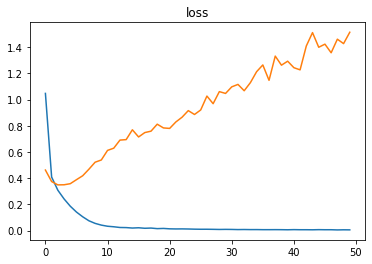

In [66]:
import matplotlib.pyplot as plt
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
